# scGenePT Perturbation Prediction Tutorial 

<a id = 'introduction'></a>
Last Updated: [11/14/2024] This notebook offers examples of how to use trained scGenePT models in inference mode for perturbation prediction. It uses models fine-tuned on the **Norman [1] dataset** and offers examples of predicting post-perturbation expression responses for **single gene perturbations**: POU3F2, CDKN1B and **gene combinations**: SAMD1+ZBTB1. Models have not been evaluated on multiple gene combination perturbation responses, so behavior is unknown. 

**Model** : scGenePT is a collection of single-cell models for perturbation prediction. It leverages the [scGPT](https://github.com/bowang-lab/scGPT) [2] foundation model for scRNAseq data by injecting language embeddings at the gene level into the model architecture. The language gene embeddings are obtained by embedding gene level information from different knowledge sources using LLMs. The knowledge sources used include NCBI gene descriptions, UniProt protein Summaries for protein coding genes - as inspired by the [genePT](https://github.com/yiqunchen/GenePT) [3] approach - and GO (Gene Ontology) Gene Molecular Annotations, across three different axes: Molecular Function, Biological Process and Cellular Component. The model variations available are:
- **scGenePT_NCBI** = scGPT + NCBI Gene Card Summaries
- **scGenePT_NCBI+UniProt** = scGPT + NCBI Gene Card Summaries + UniProt Protein Summaries
- **scGenePT_GO−F** = scGPT + GO Molecular Functions Annotations
- **scGenePT_GO−C** = scGPT + GO Cellular Components Annotations
- **scGenePT_GO−P** = scGPT + GO Biological Processes Annotations
- **scGenePT+GO−all** = scGPT + GO_F + GO_C + GO_P

**Dataset**: The Norman Dataset [1] is a CRISPR perturb-seq dataset containing single and two-gene perturbations. We use a processed version of the dataset that contains 105 single and 131 two-gene combinations perturbations coming from 91k observations. Cells in the dataset are log-normalized and filtered to the top 5000 highly variable genes. Models in ths notebook are trained on the train split of the dataset. We offer examples of:
- performing inference on the test split of the Norman dataset
- performing inference on a random control sample and on a new anndata file

**The notebook is structured and offers the following examples**:
1. [Perturbation prediction](#perturbation_prediction)
    - [Load the Norman dataset](#load_dataset)
    - [Load a trained scGenePT model](#load_trained_scgenept_model)
2. [Plotting the top 20 Differentially Expressed Genes post-perturbation](#plot_top_20_de)
    - [Predicting perturbation response for perturbing the POU3F2 gene using a scGenePT_GO−C model](#example_POU3F2+ctrl)
    - [Predicting perturbation response for perturbing the CDKN1B gene using a scGenePT_GO−C model](#example_CDKN1B+ctrl)
    - [Predicting perturbation response for perturbing the SAMD1+ZBTB1 gene combination using a scGenePT_NCBI+UniProt model](#example_SAMD1+ZBTB1) 
3. [Perturbation prediction on NumPy arrays holding control samples](#prediction_on_rnd_ctrl)
4. [Perturbation prediction on AnnData files](#prediction_on_new_anndata_file)

<!-- **The full list of resources available is**:
1. [bioRxiv Preprint](https://www.biorxiv.org/content/10.1101/2024.10.23.619972v1)
2. [scGenePT Trained Model Weights](https://drive.google.com/drive/u/0/folders/12h1hL3cJF3W0VG92JqGJ1-4R-2nDXbzc)
3. [Gene Embeddings, computed using LLMs](https://drive.google.com/drive/folders/191d8uXaoUNvvZ8DZHzlR1O6BK9vLnqqy?usp=drive_link) <br>
• NCBI Gene Card summaries, NCBI Gene Card Summaries + UniProt Protein Summaries <br>
• GO-C Cellular Components Gene Annotations, GO-F Molecular Function Gene Annotations, GO-P Biological Process Gene Annotations, GO-all (GO-C + GO-F + GO-P) -->

## Setup

**Hardware Requirements** <br>
We strongly recommend running this notebook on a GPU instance. It should run on a CPU as well, but it will be much slower.

**Prerequisites**
1. The notebook must run inside a virtual env containing the needed packages. If you already created one, then you can skip this step. If you haven't, you must create one. First, you'll need to clone the repo through: <br>

```
git clone git@github.com:czi-ai/scGenePT.git
```


Then you need to create a virtual environment containing the model packaging dependencies. The `requirements.txt` file is under the repo.

```python
conda create -y --name scgenept python=3.10
source activate scgenept
pip install -r requirements.txt
pip install flash-attn --no-build-isolation
pip install scgpt "flash-attn<1.0.5"
```

2. Once you have a venv created, activate it and allow the jupyter notebook to use it as a kernel by running the following command from the terminal. If jupyter is not installed, it should be:
```python
pip install ipykernel
pip install jupyter
python -m ipykernel install --user --name=scgenept
```

3. Open the jupyter notebook. You should now be able to see and select a new kernel: scgenept. The notebook needs to be ran inside this kernel in order for all packages to be properly installed.

**Model and Data**

These steps are also described under the [GitHub README](https://github.com/czi-ai/scGenePT/blob/main/README.md): 
- **Download Gene Embeddings** - the gene embeddings files should be under `models/gene_embeddings` - you only need to download the gene embeddings of the models you are interested in. In this tutorial, we will focus on **scGenePT_GO−C** and **scGenePT_NCBI+UniProt**, so you need to download:
    - GO_C_gene_embeddings-gpt3.5-ada-concat.pickle | [Download Link](https://drive.google.com/file/d/1oGnxs56GqGQA5gaocg4uPf_UwtomJ0Tp/view?usp=drive_link)
    - NCBI+UniProt_embeddings-gpt3.5-ada.pkl | [Download Link](https://drive.google.com/file/d/1EyuQwY8B3DU3W2VBuiBSoJiJw7KHntu4/view?usp=drive_link)
- **Download Trained scGenePT models from the scGenePT Model Zoo** - they should be under `models/finetuned` for the purpose of this tutorial, we need the following models:
    - scgpt/norman/best_model_seed_42.pt | [Download Link](https://drive.google.com/file/d/1OzTVmj24k_QrLAwKkwv8Q6SNW4yDcW00/view?usp=drive_link) 
    - scgenept_go_c/norman/best_model_gpt3.5_ada_rnd_seed_42_concat.pt | [Download Link](https://drive.google.com/file/d/17tsBhTkuEw1uwTSvsK9Hskq3px_3MIQU/view?usp=drive_link)
    - scgenept_ncbi+uniprot/best_model_gpt3.5_ada_rnd_seed_42.pt | [Download Link](https://drive.google.com/file/d/1w7lGESKGzYRzuHSOaUwJj0ALyiFADxYi/view?usp=drive_link) <br>
Note that you can download all finetuned models from [this link](https://drive.google.com/drive/folders/1U9PodoV7A-Dkk-GemmLB_AzmkgE-owp_?usp=drive_link).
- **(Optional) Download Gene Annotations** - this can help visualize some of the gene annotations that got embedded; they should be under `models/gene_embeddings/gene_annotations`:
     - gene_ontology_C.csv | [Download Link](https://drive.google.com/file/d/1KDi5WnTh1AGOvg1GO868WudVQJeo64Xi/view?usp=drive_link)
     - gene_ontology_P.csv | [Download Link](https://drive.google.com/file/d/1sDjQSxLRYDyyt1CCGdVS-FuL9mp6OhdX/view?usp=drive_link)
     - gene_ontology_F.csv | [Download Link](https://drive.google.com/file/d/19QquVKvvFD3yzlJGjbYtIspgTeSr41V1/view?usp=drive_link)
     - NCBI_summary_of_genes.json | [Download Link](https://drive.google.com/file/d/118lo79pIhOs5lhIv6aNuoaNhnGnjquNC/view?usp=drive_link)
     - NCBI_UniProt_summary_of_genes.json | [Download Link](https://drive.google.com/file/d/1kiENkEdR74BPhNo9Zxu2iwBi2kSJDWtH/view?usp=drive_link)

**Your folder structure should now look something like**:

```
- models
    - pretrained
        - scgpt/vocab.json
    - gene_embeddings
        - GO_C_gene_embeddings-gpt3.5-ada-concat.pickle
        - NCBI+UniProt_embeddings-gpt3.5-ada.pkl
        - gene_annotations
            - gene_ontology_C.csv
            - gene_ontology_P.csv
            - gene_ontology_F.csv
            - NCBI_summary_of_genes.json
            - NCBI_UniProt_summary_of_genes.json
    - finetuned
        - scgenept_go_c/norman/best_model_gpt3.5_ada_rnd_seed_42_concat.pt
        - scgenept_ncbi+uniprot/norman/best_model_gpt3.5_ada_rnd_seed_42_concat.pt
- tutorials
    - scgenept_tutorial.ipynb
```

In [1]:
import sys
sys.path.insert(1, '../')

from train import load_dataloader
from utils.data_loading import *
from models.scGenePT import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from gears.inference import evaluate, compute_metrics, deeper_analysis, non_dropout_analysis

/opt/jupyter-envs/lang-generative-single-cell/aistrate-8gpu-3/conda/envs/scgenept2/lib/python3.10/site-packages/einops/_torch_specific.py:109: ImportWarning: allow_ops_in_compiled_graph failed to import torch: ensure pytorch >=2.0
  warnings.warn("allow_ops_in_compiled_graph failed to import torch: ensure pytorch >=2.0", ImportWarning)


<a id='perturbation prediction'></a>
## 1. Perturbation Prediction using a trained scGenePT model

<a id='load_dataset'></a>
### Load dataset
We start by loading the Norman dataset. The dataloaders use a pre-processed version of Norman from [GEARS](https://github.com/snap-stanford/GEARS) [3]. Models in this notebook have been finetuned on the train split of this dataset. We also showcase how to perform inference on the test split of this dataset. 

In [2]:
# Has been tested with 'norman' and 'adamson'
dataset_name = 'norman' 
batch_size = 64
eval_batch_size = 64

pert_data = load_dataloader(dataset_name, batch_size, eval_batch_size, split = 'simulation')
train_loader = pert_data.dataloader['train_loader']
val_loader = pert_data.dataloader['val_loader']
test_loader = pert_data.dataloader['test_loader']

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!
Creating dataloaders....
Done!


<a id='dataset_exploration'></a>
### Dataset Exploration

We can examine the data inside the dataloaders. The `pert_data.adata` is an AnnData object containing gene expression counts and additional information.

In [3]:
pert_data.adata

AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

The gene expression counts are stored in `pert_adata.adata.X`, where each entry (i, j) entry corresponds to the gene expression counts of gene j in row i

In [4]:
pert_data.adata.X # 902105 cells, 5045 genes

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 37317477 stored elements and shape (91205, 5045)>

The `pert_data.adata.obs` file contains information about the different perturbation conditions applied to the data stored in .X. For instance, below we can see examples of 1-gene perturbations: *TSC22D1+ctrl, MAML2+ctrl*, etc, examples of 2-gene perturbations: *KLF1+MAP2K6, CEBPE+RUNX1T1*, and examples of control samples. Each of the conditions corresponds to gene expression counts stored in .X.

In [5]:
pert_data.adata.obs # perturbation conditions applied to the 902105 cells

,condition,cell_type,dose_val,control,condition_name
cell_barcode,,,,,
AAACCTGAGGCATGTG-1,TSC22D1+ctrl,A549,1+1,0,A549_TSC22D1+ctrl_1+1
AAACCTGAGGCCCTTG-1,KLF1+MAP2K6,A549,1+1,0,A549_KLF1+MAP2K6_1+1
AAACCTGCACGAAGCA-1,ctrl,A549,1,1,A549_ctrl_1
AAACCTGCAGACGTAG-1,CEBPE+RUNX1T1,A549,1+1,0,A549_CEBPE+RUNX1T1_1+1
AAACCTGCAGCCTTGG-1,MAML2+ctrl,A549,1+1,0,A549_MAML2+ctrl_1+1
...,...,...,...,...,...
TTTGTCAGTCATGCAT-8,RHOXF2BB+SET,A549,1+1,0,A549_RHOXF2BB+SET_1+1
TTTGTCATCAGTACGT-8,FOXA3+ctrl,A549,1+1,0,A549_FOXA3+ctrl_1+1
TTTGTCATCCACTCCA-8,CELF2+ctrl,A549,1+1,0,A549_CELF2+ctrl_1+1


The `pert_data.adata.var` gives us the set of genes:

In [6]:
print(f'There are {len(pert_data.adata.var)} number of genes present in the dataset.')
pert_data.adata.var.head() # the names of the 5045 genes

There are 5045 number of genes present in the dataset.


,gene_name
gene_id,
ENSG00000239945,RP11-34P13.8
ENSG00000223764,RP11-54O7.3
ENSG00000187634,SAMD11
ENSG00000187642,PERM1
ENSG00000188290,HES4


<a id='load_trained_scgenept'></a>
### Load trained scGenePT models

In this section, we show examples of loading multiple scGenePT models for prediction in order to compare them. All the models under the scGenePT Model Zoo can be found under [GitHub repo](https://github.com/czi-ai/scGenePT/) and the trained model weights under [this GDrive link](https://drive.google.com/drive/folders/1U9PodoV7A-Dkk-GemmLB_AzmkgE-owp_?usp=drive_link)<br>

Here, we load the following:
- **scGPT** = scGPT | [Download Link](https://drive.google.com/file/d/17tsBhTkuEw1uwTSvsK9Hskq3px_3MIQU/view?usp=drive_link)
- **scGenePT_NCBI+UniProt** = scGPT + NCBI Gene Card Summaries + UniProt Protein Summaries | [Download Link](https://drive.google.com/file/d/17tsBhTkuEw1uwTSvsK9Hskq3px_3MIQU/view?usp=drive_link)
- **scGenePT_GO−C** = scGPT + GO Cellular Components Annotations | [Download Link](https://drive.google.com/file/d/17tsBhTkuEw1uwTSvsK9Hskq3px_3MIQU/view?usp=drive_link)

Note that models are assumed to be under the `models/finetuned/{dataset_name}/{model_type}/best_model_seed_42.pt` folder


**Once the Google Drive files are public, this section should use gdown to automatically download the data under the right folder structure**

In [7]:
def load_trained_scgenept_model(pert_data, model_type, models_dir, model_location, device, verbose = False):
    embs_to_include = get_embs_to_include(model_type)
    vocab_file = models_dir + 'pretrained/scgpt/vocab.json'
    vocab, gene_ids, dataset_genes, gene2idx = match_genes_to_scgpt_vocab(vocab_file, pert_data, True, SPECIAL_TOKENS)
    ntokens = len(vocab)  # size of vocabulary
    genept_embs, genept_emb_type, genept_emb_dim, found_genes_genept = initialize_genept_embeddings(embs_to_include, dataset_genes, vocab, model_type, models_dir)
    go_embs_to_include, go_emb_type, go_emb_dim, found_genes_go = initialize_go_embeddings(embs_to_include, dataset_genes, vocab, model_type, models_dir)
    
    if device == 'cpu':
        use_fast_transformer = False
    else: 
        use_fast_transformer = True
        
    model = scGenePT(
        ntoken=ntokens,
        d_model=EMBSIZE,
        nhead=NHEAD,
        d_hid=D_HID,
        nlayers=NLAYERS,
        nlayers_cls=N_LAYERS_CLS,
        n_cls=N_CLS,
        vocab=vocab,
        n_perturbagens=2,
        dropout=0.0,
        pad_token=PAD_TOKEN,
        pad_value=PAD_VALUE,
        pert_pad_id=PERT_PAD_ID,
        use_fast_transformer=use_fast_transformer,
        embs_to_include = embs_to_include,
        genept_embs = genept_embs, 
        genept_emb_type = genept_emb_type, 
        genept_emb_size = genept_emb_dim,
        go_embs_to_include = go_embs_to_include,
        go_emb_type = go_emb_type,
        go_emb_size = go_emb_dim
    )
    
    pretrained_params = torch.load(model_location, weights_only=True, map_location = device)
    # print(pretrained_params)
    if not use_fast_transformer:
        pretrained_params = {
            k.replace("Wqkv.", "in_proj_"): v for k, v in pretrained_params.items()
        }
    
    model.load_state_dict(pretrained_params)
    
    if verbose:
        print(model)
    model.to(device)
    return model, gene_ids

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device {device}')

# Mapping from model name to the name of the model file model weights are saved
# Note that if you want to experiment with only one or a couple of models only, not all models need to be downloaded
model_name2model_variation = {'scgpt' : 'best_model_seed_42.pt',
                    'scgenept_ncbi+uniprot_gpt' : 'best_model_gpt3.5_ada_rnd_seed_42.pt',
                    'scgenept_go_c_gpt_concat' : 'best_model_gpt3.5_ada_rnd_seed_42_concat.pt'}

# To load all the models, uncomment this code and download the specific models from the GDrive link above
# model_name2model_variation = {'scgpt' : 'best_model_seed_42.pt', 
#                     'scgenept_ncbi_gpt' : 'best_model_gpt3.5_ada_rnd_seed_42.pt',
#                     'scgenept_ncbi+uniprot_gpt' : 'best_model_gpt3.5_ada_rnd_seed_42.pt',
#                     'scgenept_go_c_gpt_concat' : 'best_model_gpt3.5_ada_rnd_seed_42_concat.pt',
#                     'scgenept_go_f_gpt_concat' : 'best_model_gpt3.5_ada_rnd_seed_42_concat.pt',
#                     'scgenept_go_p_gpt_concat' : 'best_model_gpt3.5_ada_rnd_seed_42_concat.pt',
#                     'scgenept_go_all_gpt_concat' : 'best_model_gpt3.5_ada_rnd_seed_42_concat.pt'}

# Names of the scGenePT models to load. Note that these have to match the keys in the model_name2model_variation dict
models = ['scgpt', 'scgenept_go_c_gpt_concat', 'scgenept_ncbi+uniprot_gpt']
# models = ['scgpt',  'scgenept_go_c_gpt_concat', 'scgenept_go_p_gpt_concat', 'scgenept_go_f_gpt_concat', 'scgenept_go_all_gpt_concat', 'scgenept_ncbi_gpt', 'scgenept_ncbi+uniprot_gpt']
trained_models = {}

# Location of where the pretrained scGPT model and gene embeddings are located
pretrained_scgpt_model_dir = '../models/'

for model_name in models:
    print(f"Now loading a {model_name} model ... ")
    print('=' * 30)
    model_filename = model_name2model_variation[model_name]
    if model_name != 'scgpt':
        model_prefix = ''.join(model_name.split('_gpt')[:-1]) 
    else:
        model_prefix = model_name
    model_location =  f'../models/finetuned/{model_prefix}/{dataset_name}/{model_filename}'
    model, gene_ids =  load_trained_scgenept_model(pert_data, model_name, pretrained_scgpt_model_dir, model_location, device)
    print('Done!\n')
    trained_models[model_name] = model

Using device cuda
Now loading a scgpt model ... 
scGenePT model-type: scgpt
match 4547/5045 genes in vocabulary of size 60697.
Using the following embeddings:['scGPT_counts_embs', 'scGPT_token_embs']
Done!

Now loading a scgenept_go_c_gpt_concat model ... 
scGenePT model-type: scgenept_go_c_gpt_concat
match 4547/5045 genes in vocabulary of size 60697.
Using c GO embs
Matched 2945 out of 5045 genes in the GenePT-w embedding
Using the following embeddings:['GO_token_embs_gpt_concat', 'scGPT_counts_embs', 'scGPT_token_embs']
Done!

Now loading a scgenept_ncbi+uniprot_gpt model ... 
scGenePT model-type: scgenept_ncbi+uniprot_gpt
match 4547/5045 genes in vocabulary of size 60697.
Using ncbi+uniprot genept embs, embedded with gpt
Matched 3351 out of 5045 genes in the GenePT-w embedding
Using the following embeddings:['scGPT_counts_embs', 'scGPT_token_embs', 'genePT_token_embs_gpt']
Done!



<a id='plot_top_20_de'></a>
## 2. Plot the Top Differentially Expressed Genes post-perturbation
We can use the trained models to perform inference. Below, we offer an example of how to do this on the test split of the Norman dataset - this is novel data the model has not been trained on. The same workflow/analyses can be applied to other data to get similar insights. For instance, in the following sections we offer examples of performing inference  on completely new data, either in numpy or anndata form.

We explore the following scenarios and showcase how to plot the top differentially expressed genes post-perturbation for: <br>
• **single-gene perturbation**: predicting the effects of perturbing the POU3F2 gene and the CDKN1B gene individually. We offer examples of comparing scGPT with scGenePT_GO−C model predictions <br>
• **two-gene perturbation**: predicting the effect of perturbing the SAMD1+ZBTB1 genes simultaneously. We offer an example of comparing scGPT and scGenePT_NCBI+UniProt model predictions

In [9]:
def plot_perturbation(
    model: nn.Module, query: str, model_type, color, marker, title, save_file: str = None, amp = True, pool_size: int = None
):
    import seaborn as sns
    import numpy as np
    import matplotlib.pyplot as plt

    sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

    adata = pert_data.adata
    adata_ctrl = adata[adata.obs['condition'] == 'ctrl']
    gene_names = pert_data.gene_names.to_list()
    
    gene2idx = pert_data.node_map
    cond2name = dict(adata.obs[["condition", "condition_name"]].values)
    gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))

    de_idx = [
        gene2idx[gene_raw2id[i]]
        for i in adata.uns["top_non_zero_de_20"][cond2name[query]]
    ]
    genes = [
        gene_raw2id[i] for i in adata.uns["top_non_zero_de_20"][cond2name[query]]
    ]
    truth = adata[adata.obs.condition == query].X.toarray()[:, de_idx]
    model = model.to('cuda')
    print(device)
    pred = model.pred_perturb_from_ctrl(adata_ctrl, query, gene_names, device, gene_ids, amp, pool_size).squeeze()[de_idx]
    ctrl_means = adata[adata.obs["condition"] == "ctrl"].to_df().mean()[de_idx].values

    pred = pred - ctrl_means
    truth = truth - ctrl_means

    plt.figure(figsize=[16.5, 4.5])
    plt.title(title + '\n' + query)
    plt.boxplot(truth, showfliers=False, medianprops=dict(linewidth=0))

    for i in range(pred.shape[0]):
        _ = plt.scatter(i + 1, pred[i], color=color, marker=marker)

    plt.axhline(0, linestyle="dashed", color="green")

    ax = plt.gca()
    ax.xaxis.set_ticklabels(genes, rotation=90)

    plt.ylabel("Change in Gene Expression over Control", labelpad=10)
    plt.tick_params(axis="x", which="major", pad=5)
    plt.tick_params(axis="y", which="major", pad=5)
    sns.despine()

Before we perform predictions, we can explore the test split of the Norman dataset in more detail. We are interested in this split, because this is data that the model has not seen during training. So performance on this split gives us a sense of model performance on unseen data. The `pert_data.subgroup` object contains information about the set of perturbations present in each of the train/val/test splits, and each can be explored in more detail. For example, the perturbation types in the test set are split into the following categories: 
- **unseen_single**: single gene perturbations that have not been seen during training
- **combo_seen0**: two-gene perturbations, none of the genes has been seen perturbed (individually or as part of a combination) during training 
- **combo_seen1**: two-gene perturbations, one of the genes has been seen perturbed (individually or as part of a combination) during training
- **combo_seen2**: two-gene perturbations, both genes has been seen perturbed (individually or as part of a combination) during training

In [10]:
pert_data.subgroup['test_subgroup'].keys()

unseen_single = pert_data.subgroup['test_subgroup']['unseen_single']
combo_seen0 = pert_data.subgroup['test_subgroup']['combo_seen0']
combo_seen1 = pert_data.subgroup['test_subgroup']['combo_seen1']
combo_seen2 = pert_data.subgroup['test_subgroup']['combo_seen2']

print(f'unseen_single: {len(unseen_single)}, combo_seen0: {len(combo_seen0)}, combo_seen1: {len(combo_seen1)}, combo_seen2: {len(combo_seen2)}')

unseen_single: 37, combo_seen0: 9, combo_seen1: 52, combo_seen2: 18


Examples of combinations of genes where none of the genes has been seen during training:

In [11]:
combo_seen0

['POU3F2+FOXL2',
 'ZBTB10+PTPN12',
 'CEBPB+PTPN12',
 'CBL+PTPN12',
 'RHOXF2BB+SET',
 'CDKN1C+CDKN1B',
 'CDKN1C+CDKN1A',
 'CDKN1B+CDKN1A',
 'C3orf72+FOXL2']

<a id='example_POU3F2+ctrl'></a>
### Single-Gene Perturbation: Predicting perturbation response for perturbing the POU3F2 gene

Then we can start exploring prediction on some of these perturbation categories. In the example below, we compare the perturbation prediction responses of scGPT and scGenePT_GO-C - scGPT + GO Cellular Components Annotations by perturbing the POU2F2 gene. Note that this gene has not been seen perturbed during training by the model. We do this by sampling n = 300 random controls from the training dataset and taking the mean of the average prediction for each control. According to NCBI Gene Card https://www.ncbi.nlm.nih.gov/gene/5454, overexpression of the protein encoded by POU3F2 is associated with an increase in the proliferation of melanoma cells. We can see that the genes FABP5, HSP90AB1, PRDX1, NPM1, TMSB10, PTMA are all better predicted as having a negative fold change over control by scGenePTGO−C, compared to scGPT which predicts a non-significant effect. 

cuda
cuda


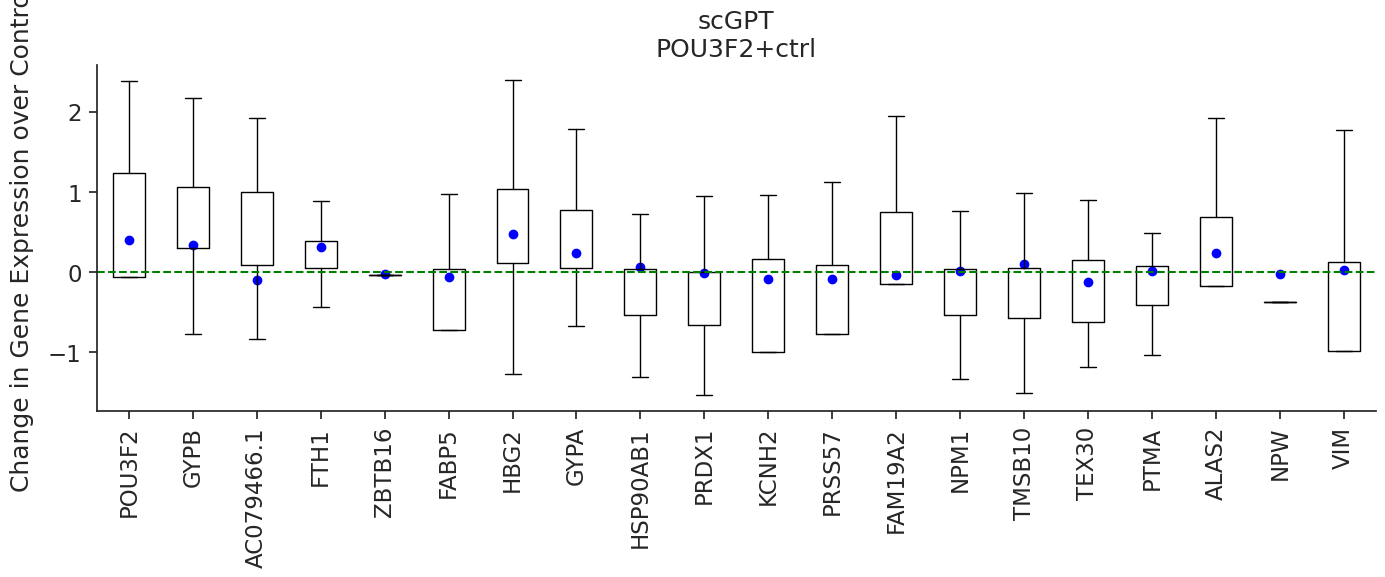

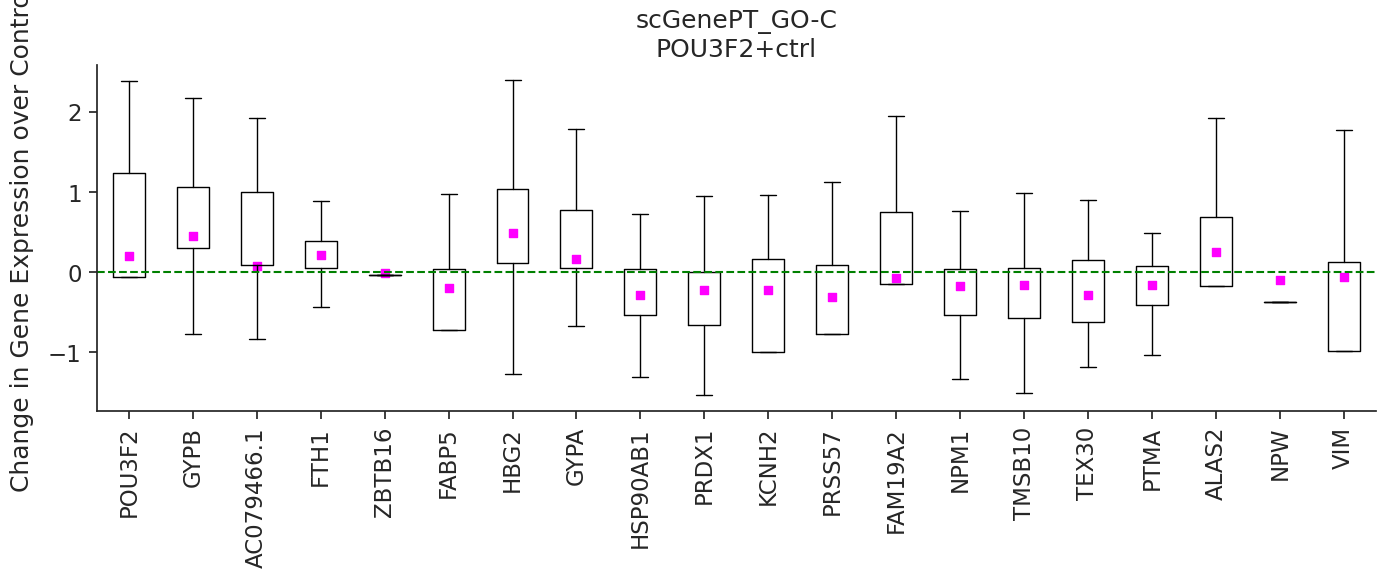

In [12]:
pert = 'POU3F2+ctrl'
colors = ['blue', 'fuchsia']
marker_types = [ 'o','s']
models_to_predict = ['scgpt', 'scgenept_go_c_gpt_concat']

for model, color, marker_type, title  in zip(models_to_predict, colors, marker_types, ['scGPT', 'scGenePT_GO-C']):
    plot_perturbation(trained_models[model], pert, model, color, marker_type, title, amp = True, pool_size=300)

We can inspect the GO Gene Annotations that were used for this gene during training. If you don't already have the GO annotations downloaded, they can be retrieved from [here](https://drive.google.com/drive/folders/1NrRfw5-N0GAZSOQ5EBI5xRL7dj3doHZP?usp=drive_link) and should be placed under `models/gene_embeddings/gene_annotations`

In [13]:
import pandas as pd
gene_annotations_dir = '../models/gene_embeddings/gene_annotations/'

#GO-C Cellular Component Annotations
GO_C_annotations_df = pd.read_csv(gene_annotations_dir + 'gene_ontology_C.csv')
#GO-P Biological Process Annotations
GO_P_annotations_df = pd.read_csv(gene_annotations_dir + 'gene_ontology_P.csv')
#GO-F Molecular Function Annotations
GO_F_annotations_df = pd.read_csv(gene_annotations_dir + 'gene_ontology_F.csv')

For example, we can look at the GO-C Cellular Components annotations for the POU3F2 gene:

In [14]:
GO_C_annotations_df[GO_C_annotations_df['gene'] == 'POU3F2']

,gene,gene_name,ontology_aspect,direct_class_label
37738,POU3F2,"POU domain, class 3, transcription factor 2",C,nucleoplasm
37739,POU3F2,"POU domain, class 3, transcription factor 2",C,chromatin
37740,POU3F2,"POU domain, class 3, transcription factor 2",C,transcription regulator complex


By adding the GO Cellular Component annotations, the model learns that this gene is localized mostly in: nucleoplasm, chromatin and transcription regulator complex. Localization of gene products in the cell plays an important role in their biological function, e.g. protein-protein interaction; regulation of gene expression, transportation of protein. This tells us that subcellular localization is helpful in being able to predict effects of perturbation of this gene.

<a id='#example_CDKN1B+ctrl'></a>
### Single-Gene Perturbation: Predicting perturbation response for perturbing the CDKN1B gene
We can do this analysis for other genes as well. For example, the CDKN1B gene is another gene that has not been seen perturbed during training. According to this gene’s NCBI Gene Card https://www.ncbi.nlm.nih.gov/gene/1027, mutations in this gene are associated with multiple enodcrine neoplasia type IV. We can see that scGenePTGO−C predicts HSP90AA1, PTMA, RANBP1, CKS1B, PRDX1, PHF19 and NME1 as correctly down-regulated, as opposed to scGPT which predicts either neutral effect or positive fold change. Similarly, we speculate that the model learns to incorporate cellular location information to better predict gene expression change in response to genetic perturbation.

cuda
cuda


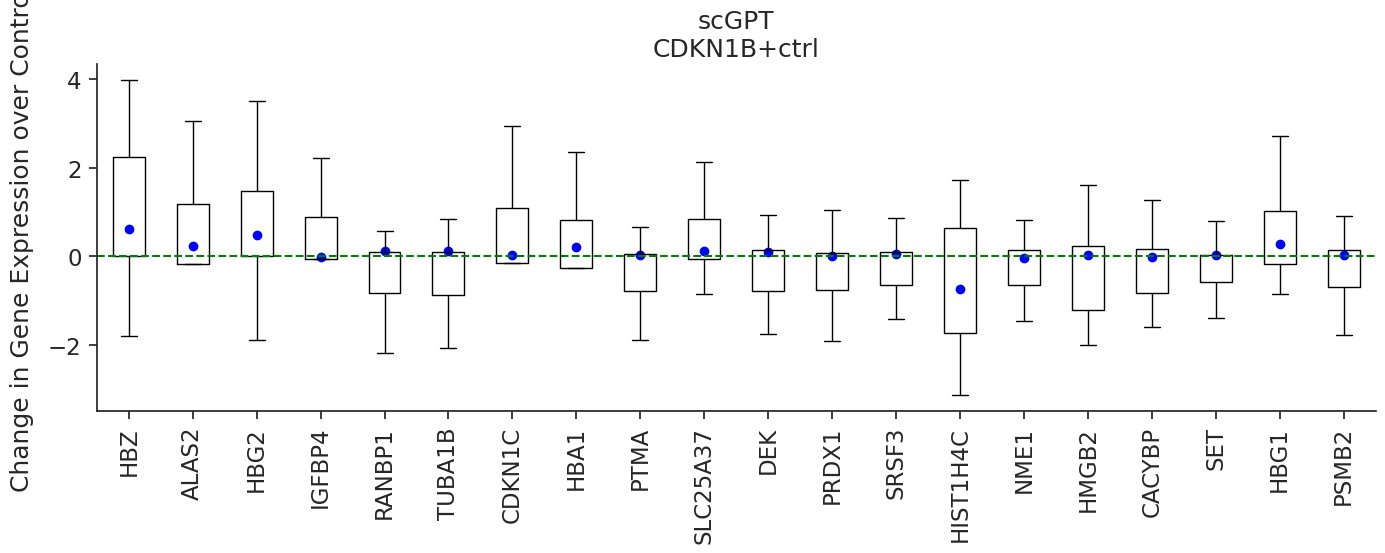

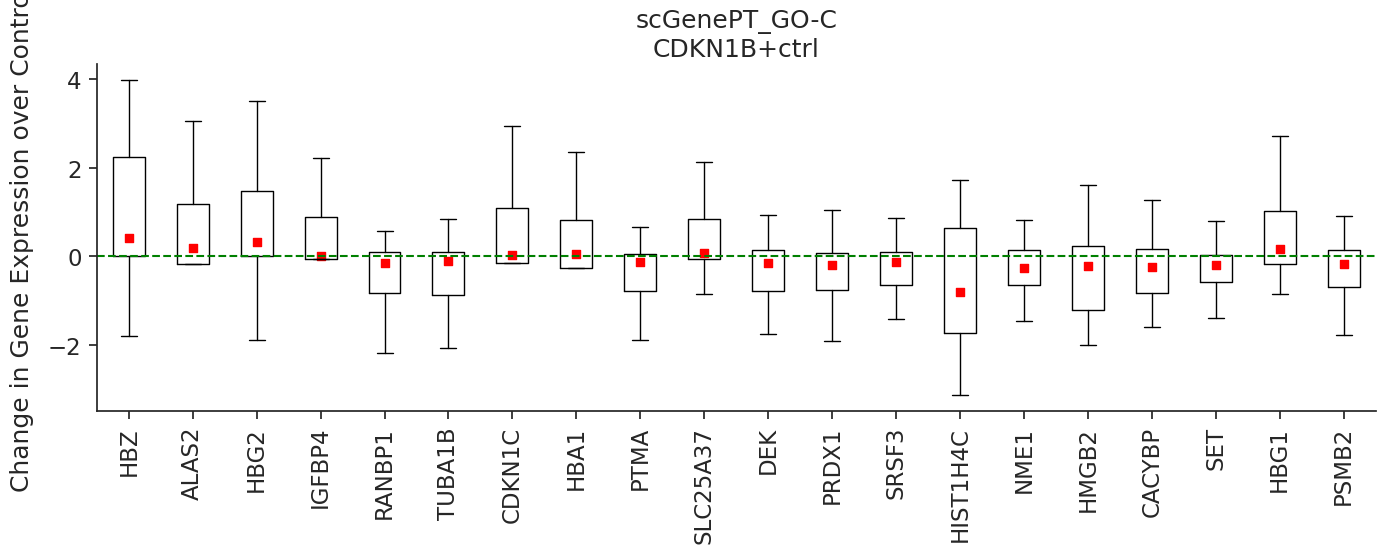

In [15]:
pert = 'CDKN1B+ctrl'
colors = ['blue', 'red']
marker_types = [ 'o','s']
models_to_predict = ['scgpt', 'scgenept_go_c_gpt_concat']

for model, color, marker_type, title  in zip(models_to_predict, colors, marker_types, ['scGPT', 'scGenePT_GO-C']):
    plot_perturbation(trained_models[model], pert, model, color, marker_type, title, amp = True, pool_size=300)

We can see that the subcellular localization annotations that the model sees during training for the CDK1NB gene are:

In [16]:
GO_C_annotations_df[GO_C_annotations_df['gene'] == 'CDKN1B']

,gene,gene_name,ontology_aspect,direct_class_label
72395,CDKN1B,Cyclin-dependent kinase inhibitor 1B,C,nucleus
72396,CDKN1B,Cyclin-dependent kinase inhibitor 1B,C,nucleoplasm
72397,CDKN1B,Cyclin-dependent kinase inhibitor 1B,C,cytoplasm
72398,CDKN1B,Cyclin-dependent kinase inhibitor 1B,C,endosome
72399,CDKN1B,Cyclin-dependent kinase inhibitor 1B,C,cytosol
72400,CDKN1B,Cyclin-dependent kinase inhibitor 1B,C,intracellular membrane-bounded organelle
72401,CDKN1B,Cyclin-dependent kinase inhibitor 1B,C,Cul4A-RING E3 ubiquitin ligase complex


We speculate that having access to this information during training is helping the model make better predictions on the effect of perturbing this gene.

<a id='#example_SAMD1+ZBTB1'></a>
### Two-gene Perturbation: Predicting perturbation response for perturbing the gene combination FOXA1+FOXL2

We can also look at effects of combination of genes. Below, we offer an example of predicting perturbation responses for the FOXA1+FOXL2 gene combination. <br>
Note that you can experiment with different gene combinations in **combo_seen0, combo_seen1**, or **combo_seen2**

cuda
cuda


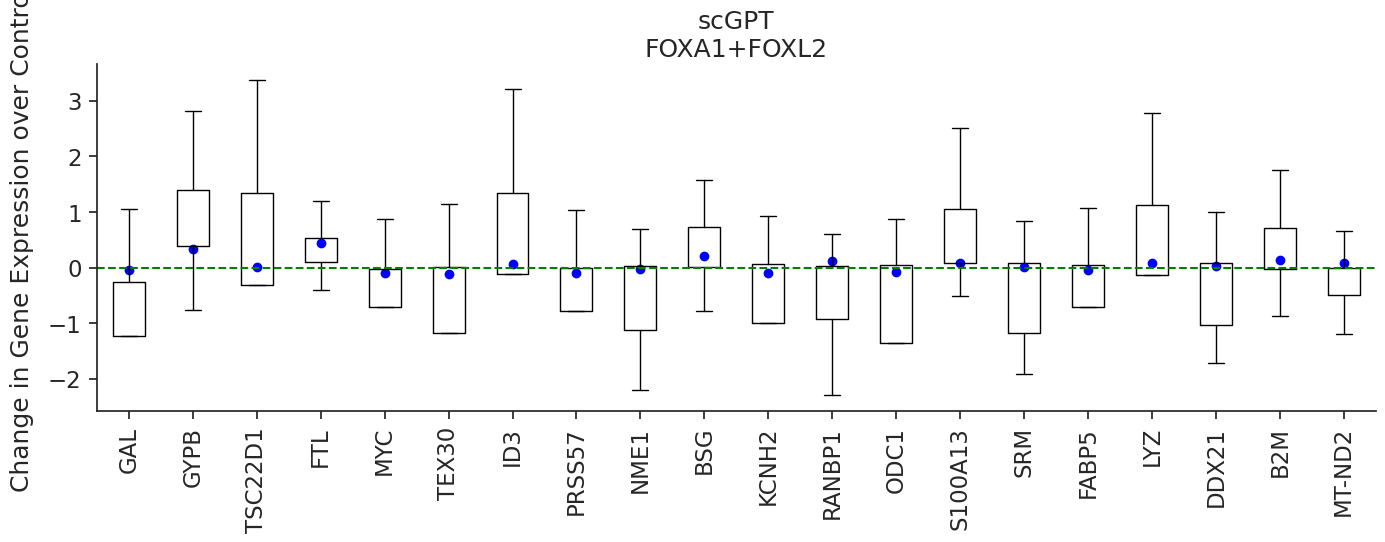

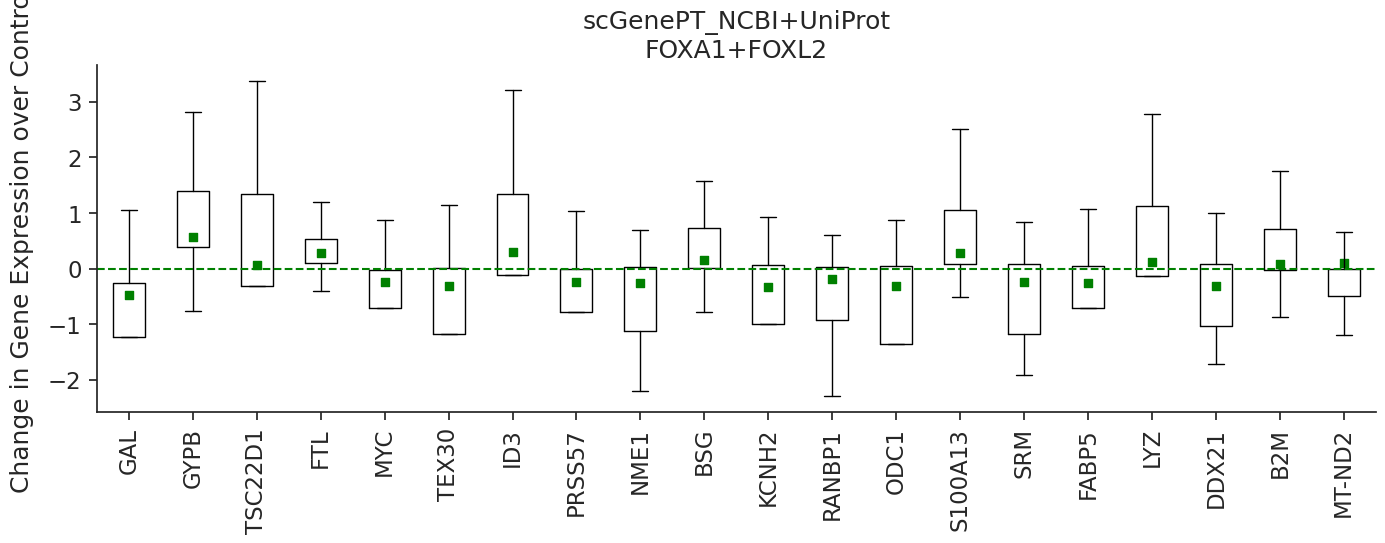

In [17]:
pert = 'FOXA1+FOXL2'
colors = ['blue', 'green']
marker_types = [ 'o', 's', 's']
models_to_predict = ['scgpt', 'scgenept_ncbi+uniprot_gpt']

for model, color, marker_type, title  in zip(models_to_predict, colors, marker_types, ['scGPT', 'scGenePT_NCBI+UniProt']):
    plot_perturbation(trained_models[model], pert, model, color, marker_type, title, amp = True, pool_size=300)

Similarly, we can look at the NCBI and UniProt annotations for the genes:

In [18]:
# NCBI Gene Card Annotations
NCBI_gene_card_summaries = json.load(open(gene_annotations_dir + 'NCBI_summary_of_genes.json', 'rb'))
# NCBI Gene Card + UniProt protein summaries Annotations
NCBI_UniProt_gene_card_protein_summaries = json.load(open(gene_annotations_dir + 'NCBI_UniProt_summary_of_genes.json', 'rb'))

comb_genes = pert.split('+')
for gene in comb_genes:
    print(f"Annotations for GENE: {gene}")
    print('='*30)
    print(f"NCBI Gene Card Summary: {NCBI_gene_card_summaries[gene]}")
    print('\n')
    print(f"NCBI Gene Card + UniProt Protein Summary: {NCBI_UniProt_gene_card_protein_summaries[gene]}")
    print('\n')

Annotations for GENE: FOXA1
NCBI Gene Card Summary: Gene Symbol FOXA1 This gene encodes a member of the forkhead class of DNA-binding proteins. These hepatocyte nuclear factors are transcriptional activators for liver-specific transcripts such as albumin and transthyretin, and they also interact with chromatin. Similar family members in mice have roles in the regulation of metabolism and in the differentiation of the pancreas and liver.


NCBI Gene Card + UniProt Protein Summary: Gene Symbol FOXA1 This gene encodes a member of the forkhead class of DNA-binding proteins. These hepatocyte nuclear factors are transcriptional activators for liver-specific transcripts such as albumin and transthyretin, and they also interact with chromatin. Similar family members in mice have roles in the regulation of metabolism and in the differentiation of the pancreas and liver. Protein summary: Transcription factor that is involved in embryonic development, establishment of tissue-specific gene express

<a id='predicting_on_rnd_ctrl'></a>
## 3. Predicting on numpy arrays holding control samples

We can make predictions on various data formats. Let's say we have a control sample held in a numpy array. We can use one of the trained models to make predictions. <br> 
For example, let's use the scGenePT-GO-C model trained on Norman. First, we need to load the trained model: 

In [19]:
model_name = 'scgenept_go_c_gpt_concat'
dataset_name = 'norman' 
pert_data = load_dataloader(dataset_name, batch_size = 64, val_batch_size = 64, split = 'simulation')

model_filename = model_name2model_variation[model_name]
model_location =  f'../models/finetuned/scgenept_go_c/{dataset_name}/{model_filename}'
model, gene_ids =  load_trained_scgenept_model(pert_data, model_name, pretrained_scgpt_model_dir, model_location, device, verbose = False)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!
Creating dataloaders....
Done!


scGenePT model-type: scgenept_go_c_gpt_concat
match 4547/5045 genes in vocabulary of size 60697.
Using c GO embs
Matched 2945 out of 5045 genes in the GenePT-w embedding
Using the following embeddings:['GO_token_embs_gpt_concat', 'scGPT_counts_embs', 'scGPT_token_embs']


Let's say we have a control sample in a `NumPy array` and we want to predict the effect of perturbing the **FOSB** gene. Note that in the example below, the order of the genes in the ctrl_sample would have to match the one in gene_names of the dataset that the model was trained on. Otherwise, additional gene name matching should be made.

In [20]:
gene_names = pert_data.gene_names.to_list()
print(f'There are {len(gene_names)} genes, the first 10 are: {gene_names[:10]}')

There are 5045 genes, the first 10 are: ['RP11-34P13.8', 'RP11-54O7.3', 'SAMD11', 'PERM1', 'HES4', 'ISG15', 'RP11-54O7.18', 'RNF223', 'LINC01342', 'TTLL10-AS1']


In [21]:
pert = "FOSB+ctrl"
ctrl_sample = np.random.rand(5045) # this can be replaced with a different control sample, as long as the order of the gene matches

Then we need to assign the correct perturbation flags in the control sequence, so that the model knows what gene should get perturbed

In [22]:
def get_pert_flags(ctrl_sample, gene_names, pert):
    pert_flags = np.zeros(len(ctrl_sample))
    if pert!= 'ctrl':
        for x in pert.split('+'):
            if x != 'ctrl':
                pert_flags[gene_names.index(x)] = 1
    pert_flags = torch.from_numpy(pert_flags).long().to(device).unsqueeze(0)
    return pert_flags

pert_flags = get_pert_flags(ctrl_sample, gene_names, pert)

Then we can get the model predictions by calling the model in inference mode:

In [23]:
def pred_ctrl_sample(model, gene_ids, ctrl_sample, pert_flags, device):
    ctrl_sample = torch.from_numpy(np.expand_dims(ctrl_sample, 0)).to(dtype = torch.float32).to(device)
    gene_ids_tensor = torch.tensor(gene_ids).long().unsqueeze(0).to(device)
    src_key_padding_mask = torch.zeros_like(gene_ids_tensor, dtype=torch.bool, device=device)
    model = model.to(torch.float32)
    with torch.cuda.amp.autocast(enabled=True):
        with torch.no_grad():
            output_dict = model(
                gene_ids_tensor,
                ctrl_sample,
                pert_flags,
                src_key_padding_mask=src_key_padding_mask,
                CLS=False,
                CCE=False,
                MVC=False,
                ECS=False,
                do_sample=True,
            )
    prediction = output_dict["mlm_output"].float().detach().cpu().numpy()
    return prediction

In [24]:
preds = pred_ctrl_sample(model, gene_ids, ctrl_sample, pert_flags, device)

In [25]:
preds

array([[-3.0040741e-03,  3.9624023e-01,  4.3334961e-03, ...,
         3.9042969e+00,  4.0283203e-01,  3.4985352e-01]], dtype=float32)

In [26]:
preds.shape

(1, 5045)

<a id='prediction_on_new_anndata_file'></a>
## 4. Predicting on AnnData files
We can follow a similar sequence to predict on an `AnnData` file. Note that in the example below, you can replace the `adata_ctrl` file with your file of choice:

In [27]:
pert_adata = pert_data.adata
adata_ctrl = pert_adata[pert_adata.obs['condition'] == 'ctrl'][:100] # this can be any other AnnData file
adata_ctrl

View of AnnData object with n_obs × n_vars = 100 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name', 'id_in_vocab'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

Note that the set and order of the genes in the AnnData file would have to match that of the genes the model has been trained on. In most cases, this will mean filtering the data to match this. The 5045 genes used by the model are:

In [28]:
adata_ctrl.var

,gene_name,id_in_vocab
gene_id,,
ENSG00000239945,RP11-34P13.8,1
ENSG00000223764,RP11-54O7.3,-1
ENSG00000187634,SAMD11,1
ENSG00000187642,PERM1,1
ENSG00000188290,HES4,1
...,...,...
ENSG00000198786,MT-ND5,1
ENSG00000198695,MT-ND6,1
ENSG00000198727,MT-CYB,1


Each of them will correspond to values in the columns of `adata_ctrl.X`:

In [29]:
adata_ctrl.X # an entry (i, j) corresponds to the value of gene j in cell i; the 5045 genes must match to the list above

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 40918 stored elements and shape (100, 5045)>

Using similarly the model loaded above to generate predictions for perturbing a particular gene perturbation X:

In [30]:
gene_pert = 'CEBPB+ctrl'

ctrl_size = None # Note that if ctrl_size = None, all ctrl samples are used; if ctrl_size != None, then ctrl_size samples will get randomly sampled.
return_mean = False # If this is True, then the mean of the predictions will get returned
preds = model.pred_perturb_from_ctrl(adata_ctrl, gene_pert, gene_names, device, gene_ids, pool_size = ctrl_size, return_mean = False).squeeze()

In [31]:
preds

array([[-3.2749176e-03,  1.0986328e-02,  8.4686279e-03, ...,
         3.8398438e+00,  1.0986328e-02,  1.0986328e-02],
       [-3.3226013e-03,  1.0871887e-02,  8.5983276e-03, ...,
         3.8378906e+00,  1.0871887e-02,  1.0871887e-02],
       [-3.2444000e-03,  1.0665894e-02,  8.7738037e-03, ...,
         3.8417969e+00,  1.0665894e-02,  1.0665894e-02],
       ...,
       [-3.2196045e-03,  1.1482239e-02,  9.0713501e-03, ...,
         3.8437500e+00,  1.1482239e-02,  1.1482239e-02],
       [-3.2596588e-03,  1.1039734e-02,  8.6822510e-03, ...,
         3.8535156e+00,  1.1039734e-02,  1.1039734e-02],
       [-3.3779144e-03,  1.0910034e-02,  8.7127686e-03, ...,
         3.8437500e+00,  1.0910034e-02,  1.0910034e-02]], dtype=float32)

In [32]:
preds.shape

(100, 5045)

We can then assign the predictions to the anndata file:

In [33]:
adata_ctrl.layers[f'{model_name}_predictions'] = preds

In [34]:
adata_ctrl

AnnData object with n_obs × n_vars = 100 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name', 'id_in_vocab'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts', 'scgenept_go_c_gpt_concat_predictions'

To get a mean prediction over ctrl_size control samples, we can run: 

In [35]:
ctrl_size = 300
preds_mean = model.pred_perturb_from_ctrl(adata_ctrl, gene_pert, gene_names, device, gene_ids, pool_size = ctrl_size, return_mean = True).squeeze()

In [36]:
preds_mean

array([-3.2871945e-03,  1.2714665e-02,  8.5241701e-03, ...,
        3.8420312e+00,  1.0882238e-02,  1.0882238e-02], dtype=float32)

In [37]:
preds_mean.shape

(5045,)

<a id='contact'></a>
## Contact & Feedback

Ana-Maria Istrate, aistrate@chanzuckerberg.com

## References

1. Norman, Thomas M., et al. "Exploring genetic interaction manifolds constructed from rich single-cell phenotypes." Science 365.6455 (2019): 786-793.
2. Cui, Haotian, et al. "scGPT: toward building a foundation model for single-cell multi-omics using generative AI." Nature Methods (2024): 1-11.
3. Chen, Yiqun, and James Zou. "GenePT: a simple but effective foundation model for genes and cells built from ChatGPT." bioRxiv (2024): 2023-10.
4. Roohani, Yusuf, Kexin Huang, and Jure Leskovec. "Predicting transcriptional outcomes of novel multigene perturbations with GEARS." Nature Biotechnology 42.6 (2024): 927-935.